In [28]:
import os
from collections import OrderedDict
from torch.autograd import Variable
from options.test_options import TestOptions
from models.models import create_model
import util.util as util
import torch
from data.base_dataset import get_params, get_transform
from PIL import Image
import matplotlib.pyplot as plt


opt = TestOptions().parse(save=False, isJupyter=True)
opt.nThreads = 1   # test code only supports nThreads = 1
opt.batchSize = 1  # test code only supports batchSize = 1
opt.serial_batches = True  # no shuffle
opt.no_flip = True  # no flip
opt.name = "back01_512p"
opt.label_nc = 0
opt.no_instance = True
opt.resize_or_crop = "none"

model = create_model(opt)

------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
data_type: 32
dataroot: ./datasets/cityscapes/
display_winsize: 512
engine: None
export_onnx: None
feat_num: 3
fineSize: 512
fp16: False
gpu_ids: [0]
how_many: 50
input_nc: 3
instance_feat: False
isTrain: False
label_feat: False
label_nc: 35
loadSize: 1024
load_features: False
local_rank: 0
max_dataset_size: inf
model: pix2pixHD
nThreads: 2
n_blocks_global: 9
n_blocks_local: 3
n_clusters: 10
n_downsample_E: 4
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
nef: 16
netG: global
ngf: 64
niter_fix_global: 0
no_flip: False
no_instance: False
norm: instance
ntest: inf
onnx: None
output_nc: 3
phase: test
resize_or_crop: scale_width
results_dir: ./results/
serial_batches: False
tf_log: False
use_dropout: False
use_encoded_image: False
verbose: False
which_epoch: latest
-------------- End ----------------
GlobalGenerator(
  (model): Sequential(


/root/DEV/PaintingAI/models/pix2pixHD_model.py:128: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_label = Variable(input_label, volatile=infer)


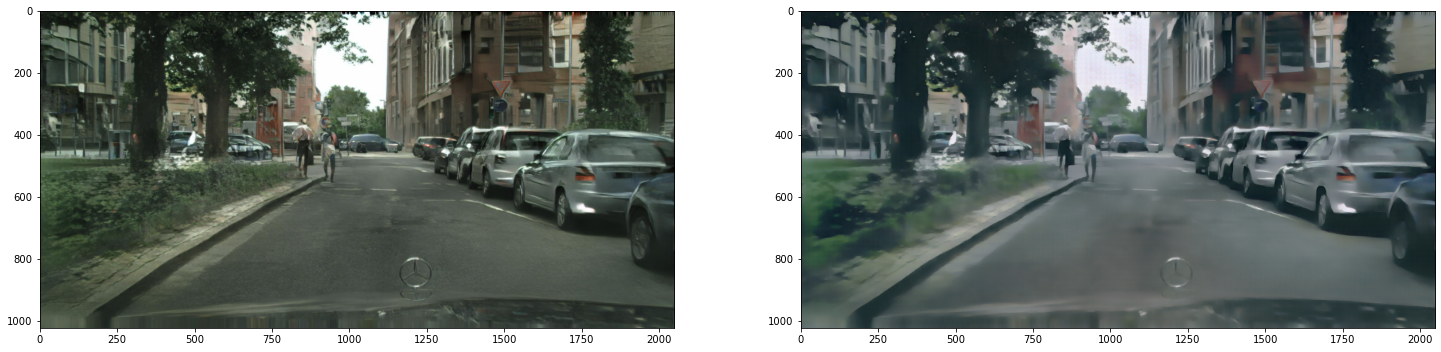

In [33]:
image_path = "imgs/cityscapes_1.jpg"
A = Image.open(image_path)        
params = get_params(opt, A.size)
transform_A = get_transform(opt, params)
A_tensor = transform_A(A.convert('RGB'))
A_tensor = A_tensor.unsqueeze(0)

generated = model.inference(A_tensor, torch.Tensor([0]), torch.Tensor([0]))
synthesized_image = util.tensor2im(generated.data[0])


fig = plt.figure(figsize=(25, 30))
fig.add_subplot(1, 2, 1)
plt.imshow(A)
fig.add_subplot(1, 2, 2)
plt.imshow(synthesized_image)
plt.show()

loading model from pretrained_models/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth


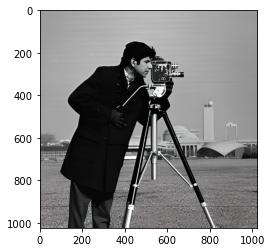

In [8]:
import numpy as np
from test_swinir import get_image_pair, setup, init_model, test
import torch
import matplotlib.pyplot as plt

model, args = init_model()
path = "../SwinIR/testsets/Set12/01.png"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
folder, save_dir, border, window_size = setup(args)

imgname, img_lq, img_gt = get_image_pair(args, path)  # image to HWC-BGR, float32
img_lq = np.transpose(img_lq if img_lq.shape[2] == 1 else img_lq[:, :, [2, 1, 0]], (2, 0, 1))  # HCW-BGR to CHW-RGB
img_lq = torch.from_numpy(img_lq).float().unsqueeze(0).to(device)  # CHW-RGB to NCHW-RGB

# inference
with torch.no_grad():
    # pad input image to be a multiple of window_size
    _, _, h_old, w_old = img_lq.size()
    h_pad = (h_old // window_size + 1) * window_size - h_old
    w_pad = (w_old // window_size + 1) * window_size - w_old
    img_lq = torch.cat([img_lq, torch.flip(img_lq, [2])], 2)[:, :, :h_old + h_pad, :]
    img_lq = torch.cat([img_lq, torch.flip(img_lq, [3])], 3)[:, :, :, :w_old + w_pad]
    output = test(img_lq, model, args, window_size)
    output = output[..., :h_old * args.scale, :w_old * args.scale]

# save image
output = output.data.squeeze().float().cpu().clamp_(0, 1).numpy()
if output.ndim == 3:
    output = np.transpose(output[[2, 1, 0], :, :], (1, 2, 0))  # CHW-RGB to HCW-BGR
output = (output * 255.0).round().astype(np.uint8)  # float32 to uint8


plt.imshow(output)